# Initial Acquisition and Equalization in OFDM

This notebook focuses on Orthogonal Frequency Division Multiplexing (OFDM). Specifically, we focus on synchronizing to the OFDM symbol structure, estimating and correcting frequency offset, and frequency domain equalization for signals received over dispersive channels.

<a href="https://colab.research.google.com/github/bepepa/digital_comms/blob/master/100_ofdm_dispersive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> (Executable notebook)

<a href="https://nbviewer.org/format/slides/github/bepepa/digital_comms/blob/main/100_ofdm_dispersive.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" alt="Render nbviewer" /> </a> (read-only, slides view)

In [12]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

from typing import Tuple

# To plot pretty figures, use matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## The code below imports functions defined in earlier notebooks

In [10]:
def pop_count32(x: np.uint32) -> np.uint8:
    """count the number of 1s in 32-bit integer x using Wegner's method
    
    Inputs:
    x - a 32 bit integer

    Returns:
    an integer between 0 and 32 indicating the number of 1s in x
    """
    
    count: np.uint8 = 0
    
    while (x > 0):
        x = x & (x-1)
        count += 1
        
    return count

In [13]:
def lfsr_step(state: np.uint32, fb: np.uint32, N: int = 31) -> Tuple[np.uint8, np.uint32]:
    """Single update step of LFSR with feedback connections fb
    
    Inputs:
    * state (uint32): initial state of the feedback shift register
    * fb (uint32): bit map indicating feedback connections; the LSB corresponds to bit 0 in the LFSR
    * N (int) order if the LFSR; must be less than 32 (default: 31)
    
    Returns:
    * elem - next element of the LFSR sequence
    * state - updated state
    
    Example: Generate the first 10 elements of a LFSR sequence with fb=0b1001 and initial state=0b1111
    >>> state = 0b1111
    >>> seq = np.empty(10, dtype=np.uint8)
    >>> for n in range(10):
    >>>     seq[n], state = lfsr31_step(state, 0b1001)
    >>> seq
    
    array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0], dtype=uint8)
    """
    
    # save the LSB before updating state; it will be returned
    elem: np.uint8 = state & 0b1
        
    # update state
    fb_vec: np.uint32 = state & fb
    fb_bit: np.uint8 = (pop_count32(fb_vec) & 0b1)
    
    # insert feedback bit at position N, then shift
    state = (state | fb_bit << N) >> 1
    
    return elem, state

In [14]:
def lfsr(init: np.uint32, fb: np.uint32, M: int, N: int = 31, Nc:int = 0):
    """Compute M samples of a LFSR sequence
    
    Inputs:
    init - initial state of the LFSR
    fb - feedback connection for the LFSR
    M - number of samples to generate
    N - order of the LFSR (default: 31)
    Nc - statrting sample (default 0)

    Returns:
    length-M vector of bits (stored as np.uint8)
    """
    seq = np.empty(M, dtype=np.uint8)

    state = init

    for n in range(Nc):
        _, state = lfsr_step(state, fb, N)          # discard the first Nc

    for n in range(M):  
        seq[n], state = lfsr_step(state, fb, N)     # keep the next Mc

    return seq

In [53]:
def random_symbols(A, N):
    """generate random symbols from the constallation A
    
    Inputs:
    A - np.ndarray of symbols in constellation, e.g., A = np.array([1, -1]) for BPSK
    N - number of random symbols to produce

    Returns:
    Numpy array of length N
    """
    return A[np.random.randint(len(A), size=N)]

## Transmitted Signal

For this notebook, we define a signalling format that is meant to resemble the downlink of  LTE and 5G NR formats. It is characterized by
* Subcarrier spacing is 15KHz
* FFT size is 2048
* Only 1272 of the subcarriers are occupied; active subcarriers are numbered from $k=0$ to $k=1271$.
* The Cyclic Prefix is 160 samples long; that corresponds to $\frac{160}{2048} \cdot \frac{1}{15\text{KHz}} = 5.2\mu s$.

Information is transmitted in slots that contain 14 OFDM symbols; the length of a slot is just under 1ms.

The first OFDM symbol in each slot contains a known synchronization reference signal. This signal occupies 127 subcarriers in the center of the active subcarriers (i.e., from $k=573$ to $k=699$).

The remaining 13 OFDM symbols contain information for three users. Eacch of the three signals occupies a different portion of the resource elements in the slot.
* user 1 occupies all 1272 active subcarriers in OFDM symbols $l=1$ to $l=4$.
* user 2 ocuppies subcarriers $k=0$ through $k=635$ in OFDM symbols $l=5$ to $l=13$
* user 3 ocuppies subcarriers $k=636$ through $k=1271$ in OFDM symbols $l=5$ to $l=13$

Each of the three signals is preceded by a demodulation reference signal (DMRS) that is located in the first allocated symbol and spans the entrire allocated bandwidth.

### Construction of a Transmitted Slot

Construction of the transmitted slot involves:
* allocating storage to hold the slot
* insertion of the synchronization reference signal
* insertion of the user data (with accompanying DMRS)
* OFDM; inverse DFT, cyclic prefix, and parallel-to-serial conversion

In [123]:
## Parameters
sc_spacing = 15e3
N_FFT = 2048
N_active = 1272
N_syms = 14
N_CP = 160

N_guard = (N_FFT - N_active) // 2

fs = sc_spacing * N_FFT

## Allocate space for a slot
Slot_active = np.zeros((N_syms, N_active), dtype=complex)

#### Synchronization Reference Signal

The synchronization reference signal is defined in the frequency domain. The resource elements holding the synchronization signal are chosen from a length 127 M-sequence. Specifically, the M-sequence generated by a linear feedback shift register with initial value $c_{init}=1$ and feedback connections described by $0x3$ is used.

In [124]:
## Generate LFSR sequence 
c_init = 1
fb = 3
M = 127
N = 7

# generate M-sequence and convert to BPSK (0 -> -1, 1 -> 1)
seq = 2.0*lfsr(c_init, fb, M, N) - 1

# insert seq into slot
Slot_active[0, 573:700] = seq

#### User signals

The signals for each of the three users consists of a training sequence DMRS that occupies the first symbol of the allocated resource elements. That is followed by the payload. We model the payload as randomQPSK symbols.

In [125]:
## define a list of dictionaries that describes where each user's signals goes
sliv_l = [
    {'id': 1,
    'l0' : 1,    # first symbol
    'le': 4,     # last symbol
    'k0': 0,     # first subcarrier
    'ke': 1271}, # last subcarrier
    {'id': 2,
    'l0': 5,
    'le': 13,
    'k0': 0,
    'ke': 635},
    {'id': 3,
    'l0': 5,
    'le': 13,
    'k0': 636,
    'ke': 1271},
]

##### DMRS signals

 The DMRS training sequences are intended to provide initialization fot the frequency domain equalizer. We will use Gold sequences that were derived from a pair of M-sequences of order 31. 

 The DMRS sequences are iitialized by the user's ID, so that the reference sequences are all distinct.

 Reference sequences are always generated to cover all subcarriers. Only the subcarriers in the user's active bandwidth will be transmitted.

 Only every fourth subcarrier will be used for training. The empty subcarriers can be used in a MIMO configuration to provide training separately for each transmit antenna.

In [178]:
## Generate the DMRS sequences for all users and insert in slot
M_dmrs = 4   # use only every fourth subcarrier

for user in sliv_l:
    id = user['id']

    # make a Gold sequence from 2 M-sequences, the second is initialized by user's id
    dmrs = lfsr(1, 9, N_active, 31, 1600) ^ lfsr(id, 15, N_active, 31, 1600)
    # convert binary to BPSK
    dmrs = 2.0*dmrs - 1.0

    # insert dmrs in first symbol of allocated bandwidth
    l0 = user['l0']
    k0 = user['k0']
    ke = user['ke']

    all_sc = np.arange(N_active)
    use_for_dmrs = np.logical_and(np.logical_and(all_sc >= k0, all_sc <= ke), all_sc % 4 == 2) # really?
    Slot_active[l0, use_for_dmrs] = dmrs[use_for_dmrs]

##### Payload

For the payoad, we insert randomly generated QPSK symbols in the allocated subcarriers.

In [179]:
A = np.exp(1j*np.pi/4*np.arange(1, 8, 2))

payloads = {}     # for storing the payloads for later comparison

for user in sliv_l:
    l0 = user['l0']
    k0 = user['k0']
    ke = user['ke']
    le = user['le']

    L = le - l0
    K = ke - k0 + 1
    pld = random_symbols(A, L*K).reshape(L,K) 

    # place in slot
    Slot_active[l0+1:le+1, k0:ke+1] = pld
    
    # store in dict for later
    payloads[user['id']] = pld



#### OFDM

Now that the slot has been constructed in the frequency domain, we need to perform OFDM. This consists of
* zero-padding to the FFT size; this also adds guard bands
* inverse DFT
* insert the cyclic prefix
* P/S conversion 

In [186]:

## OFDM
# zero-pad in frequency
Slot_FD = np.zeros((N_syms, N_FFT), dtype=complex)
Slot_FD[:, N_guard:N_guard+N_active] = Slot_active

# inverse DFT (we also need to FFT shift)
Slot = np.fft.ifft(np.fft.fftshift(Slot_FD, axes=(1,))) * np.sqrt(N_FFT)

# P/S and cyclic prefix
sig = np.zeros(N_syms * (N_FFT+N_CP), dtype=complex)
for n in range(N_syms):
    start = n * (N_FFT + N_CP)
    sig[start : start+N_CP] = Slot[n, -N_CP:]
    start += N_CP
    sig[start : start+N_FFT] = Slot[n, :]

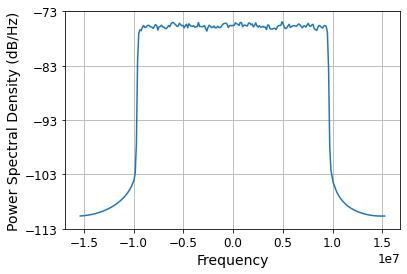

In [187]:
## check that the PSD is as expected
f,s = plt.psd(sig, Fs=fs)

## Channel

The channel introduces a delay, a frequency offset, and multi-path distortion.

In [188]:
## channel
# delay
delay_samples = 1025

# frequency offset
df = 1e3 / fs  # 1KHz

# delay by pre-pending zeros and apply frequency error
rr = np.concatenate(( np.zeros(delay_samples, dtype=complex), 
                      sig * np.exp(2j * np.pi * df * np.arange(len(sig))),
                      np.zeros(N_FFT, dtype=complex) ))


# dispersive channel
delay_spread = 1e-6  # 1 microsecond
ds_samples = int( delay_spread * fs )

c = np.zeros(ds_samples, dtype=complex)
c[:len(c)//2] = 0.5*np.exp(-0.25*np.arange(len(c)//2))
c[len(c)//2:] = 0.1*np.exp(-0.3*np.arange(len(c)//2))
c *= np.exp(2j*np.pi*np.random.rand(len(c)))
c = c / np.linalg.norm(c)

rr = np.convolve(rr, c)

# AWGN
SNR_dB = 20
SNR = 10**(SNR_dB/10)
noise_var = np.var(sig) / SNR 

# add noise 
rr = rr + np.sqrt(0.5 * noise_var) * (np.random.randn(len(rr)) + 1j*np.random.randn(len(rr))) 

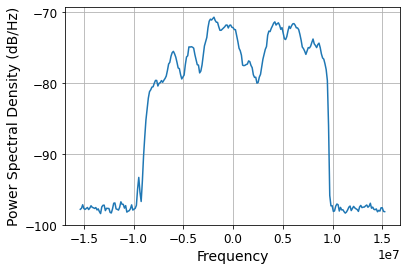

In [189]:
## check that the PSD is as expected
f,s = plt.psd(rr, Fs=fs)

## Receiver Processing

To recover the users' payloads successfully, we must:
* locate the slot and symbol boundaries boundaries
* estimate and compensate the frequency offset
* locate the resource elements that contain the users' data and perform frequency domain equalization

We perform these stepts in the indicated order.

### Find symbol boundaries via the cyclic prefix

The cyclic prefix provides a feature that can be used to identify symbol boundaries and also to derive an estimate of the frequency error.

The cyclic prefix repeats the last $N_{CP}$ samples of an OFDM symbols before the start of the symbol. We compute the following correlation to test if the cyclic prefix starts at sample index $n$
$$
\rho[n] = \sum_{k=0}^{N_{CP}-1} r[n]*r^*[n+N_{FFT}].
$$

A large absolute value of $\rho[n]$ marks the start of the preamble. Moreover. the phase of $\rho[n]$ can be used to estimate the frequency error.

As usual, it may be advantageous to use a normalized metric, e.g.,
$$
\tilde{\rho}[n] = \frac{|\sum_{k=0}^{N_{CP}-1} r[n]*r^*[n+N_{FFT}]|}{\sum_{k=0}^{N_{CP}-1} |r[n]|^2}.
$$

Additionally, in highly dispersive channels it may be beneficial to truncate the summations by eliminating the first few terms that are most impacted by the switching transient between symbols.

Below, we compute the metric $\tilde{\rho[n]}$ for all samples $n$ (for which enough data are present).

In [204]:
## Compute the correlation rho for all signal samples
# 
rho = np.zeros_like(rr)

for n in range(len(rr) - N_CP - N_FFT):
    denom = np.sum( np.abs(rr[n : n+N_CP])**2 )
    rho[n] = np.sum(rr[n : n+N_CP].conj() * rr[n+N_FFT : n+N_FFT+N_CP]) / denom

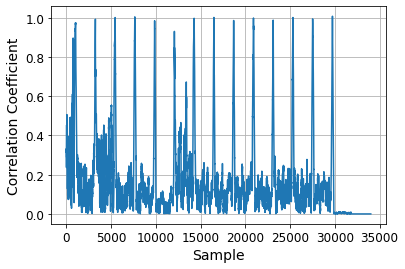

In [205]:
plt.plot(np.abs(rho))
plt.grid()
plt.xlabel("Sample")
plt.ylabel("Correlation Coefficient")

plt.show()

The normalized correlation $\tilde{\rho}[n]$ shows 14 clearly defined peaks. Each of these peaks corresponds to the start of a cyclic prefix.

Note that the regions during symbol $l=0, 1, 5$ appear noisier than the remaining symbols. This is caused by the fact that these symbols are only partially occupied.

Let's find the location of the peaks and examine their phases.

In [206]:
loc = np.zeros(N_syms, dtype=int)
corr = np.zeros(N_syms, dtype=complex)

for n in range(N_syms):
    start = delay_samples - N_FFT // 2 + n * (N_FFT + N_CP)
    end = start + N_FFT

    loc[n] = np.argmax(np.abs(rho[start:end])) + start
    corr[n] = rho[loc[n]]

We expect the difference between the locations of correlation peaks to be $N_{FFT} + N_{CP} = 2208$. Let's see if that holds.

In [207]:
## compute the difference between consecutive correlation peaks
print( np.diff(loc) )

[2215 2209 2198 2215 2208 2207 2208 2209 2215 2200 2208 2203 2214]


#### Frequency Estimation from Cyclic Prefixes

The phase difference between the cyclic prefix and the symbols at the end of the preamble is a result of frequency offset. Specifically,
the phase difference is 
$$
    \Delta \phi = 2 \pi  \frac{\Delta f}{f_s}  N_{FFT} 
$$

The phase at the locations of the correlation peaks measures this phase difference.

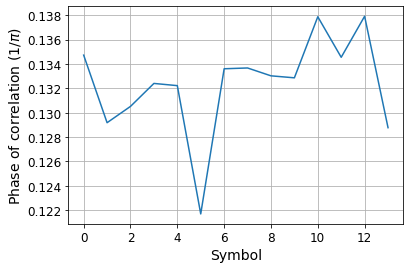

In [215]:
## plot phase of correlation peaks
plt.plot(np.angle(corr)/np.pi)
plt.grid()

plt.xlabel('Symbol')
plt.ylabel('Phase of correlation ($1/\pi$)')

plt.show()

The phase of the correlation peaks is approximately constant in each symbol period. The measured value is approximately $0.13 \pi$.

From this measurement, we can estimate the frequency offset as
$$
    \frac{2 \pi  \Delta f}{f_s} = \frac{\Delta \phi}{N_{FFT}} \quad \text{radians per sample}
$$

In absolute terms, a the measured phase difference of $0.13 \pi$ corresponds to a frequency error of 975Hz (true value is 1KHz).

We can use this estimate to initialize a frequency-locked loop and update that loop once per symbol period from a new phase measurement.

### Find slot boundaries from Synchronization reference signal

From the correlations of the cyclic prefix, we know where the symbol boundaries are. However, we must also know where the slot boundaries are since user data are arranged relative to the slot boundaries.

The synchronization reference signal provides the means to identify slot boundaries.  According to our specifications, if a symbol contains the refeence signal then it must be the first symbol in the slot.

Without knowledge about the symbol boundaries, we would have to search sample by sample for the reference signal. Knowing the sybol boundaries, we only need to check if the signal that occupies the current symbol contains the reference signal.

To do so, we correlate the time-domain reference signal against the received samples in the given symbol. This provides an opportunity to search over a few samples around the assumed start of the symbol to solidify our estimate of the symbol boundary.

We begin by constructing the reference signal.

In [220]:
## First, construct the reference signal
# Generate LFSR sequence 
c_init = 1
fb = 3
M = 127
N = 7

# generate M-sequence and convert to BPSK (0 -> -1, 1 -> 1)
seq = 2.0*lfsr(c_init, fb, M, N) - 1

# construct FD reference signal
ref_active = np.zeros(N_active, dtype=complex)
ref_active[573:700] = seq
ref_fd = np.zeros(N_FFT, dtype=complex)
ref_fd[N_guard:N_guard+N_active] = ref_active

# inverse DFT
ref_sig = np.fft.ifft(np.fft.fftshift(ref_fd)) * np.sqrt(N_FFT)

Now, we can correlate the reference signal against the received signals during each of the symbol periods. Obviously, we would do this only until we have found the reference signal. The other correlations are intended only to show that they don't correlate against the reference signal.

We use the estimated symbol boundaries from the cyclic prefix and search $\pm 50$ samples around these estimates for the best correlation.

Also, the correlation must be performed over the symbol itself - not the cyclic prefix.

**Note:** The computational efficiency of the correlation can be improved greatly by exploiting the fact that the reference signal is narrow-band as it occupies only 127 sub-carriers

In [230]:
## check each symbol to see if it contains the reference signal
corr_ref = np.zeros(N_syms, dtype=float)
loc_s = np.zeros(N_syms, dtype=int)

for n in range(N_syms):
    U = 50
    corrs = np.zeros(2*U, dtype=complex)

    for m in range(2*U):
        this_loc = loc[n] + N_CP + m - U
        corrs[m] = np.sum(rr[this_loc : this_loc+N_FFT] * ref_sig.conj())

    loc_s[n] = loc[n] + np.argmax(np.abs(corrs)) - U
    corr_ref[n] = np.max(np.abs(corrs))

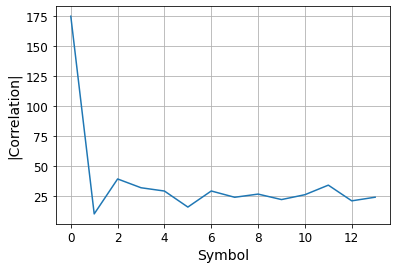

Best correlation starts at sample 1027 + N_CP


In [234]:
plt.plot(corr_ref)
plt.grid()
plt.xlabel('Symbol')
plt.ylabel('|Correlation|')

plt.show()

print("Best correlation starts at sample {:d} + N_CP".format(loc_s[0]))

### Demodulation

We have shown how the symbol and slot boundaries can be found from the synchronization reference signal and the cyclic prefix. 

Also, we have a solid estimate of the frequency error that we can use to correct the frequency error; a tracking loop is omitted here but should be included when the frequency error is time-varying.

Demodulation proceeds as follows:
* For each symbol, we extract the pertinent samples (after the cyclic prefix) and perform frequency correction
* The frequency corrected samples are then transformed to the frequency domain
* Finally, the resource elements for each user are demodulated as described in more detail below.

In [236]:
## transform signal to frequency domain
RX_fd = np.zeros((N_syms, N_FFT), dtype=complex)

for n in range(N_syms):
    # find first sample of n-th symbol
    start = loc_s[0] + N_CP + n * (N_CP + N_FFT)

    # frequency correction
    df = 0.13*np.pi /(2*np.pi)/N_FFT
    this_rr = rr[start:start+N_FFT] * np.exp(-1j * 2*np.pi * np.arange(N_FFT))

    RX_fd[n, :] = np.fft.fftshift(np.fft.fft(this_rr))

RX_active = RX_fd[:, N_guard:N_guard+N_active]

#### Extract the DMRS symbols

The DMRS symbols are used to initialize the frequency domain equalizer. We extract the resource elements that hold the DMRS symbols and multiply them with the conjugate complex of the DMRS symbols.

This provides an estimate for the complex gain for the subcarrriers holding the DMRS symbols.

For each user we needs the pertinent DMRS symbols.

In [240]:
## Generate the DMRS sequences for all users and insert in slot
M_dmrs = 4   # use only every fourth subcarrier

dmrs_seqs = {}

for user in sliv_l:
    id = user['id']

    # make a Gold sequence from 2 M-sequences, the second is initialized by user's id
    dmrs = lfsr(1, 9, N_active, 31, 1600) ^ lfsr(id, 15, N_active, 31, 1600)
    # convert binary to BPSK
    dmrs = 2.0*dmrs - 1.0

    # insert dmrs in first symbol of allocated bandwidth
    l0 = user['l0']
    k0 = user['k0']
    ke = user['ke']

    all_sc = np.arange(N_active)
    use_for_dmrs = np.logical_and(np.logical_and(all_sc >= k0, all_sc <= ke), all_sc % M_dmrs == 2) # really?

    this_dmrs = np.zeros(N_active, dtype=complex)
    this_dmrs[use_for_dmrs] = dmrs[use_for_dmrs]

    dmrs_seqs[id] = this_dmrs

In [244]:
## Derive initial equalizer values
eqs = {}

for user in sliv_l:
    # at the DMRS locations, equalizer weights can be computed directly
    id = user['id']
    l0 = user['l0']
    k0 = user['k0']
    ke = user['ke']

    # pull out the symbol that holds the DMRS
    rx_dmrs = RX_active[l0,:]
    this_dmrs = dmrs_seqs[id]

    this_eq = np.zeros_like(rx_dmrs)

    # linear interpolation between measured subcarriers
    for  k in range(k0, ke+1):
        if k % M_dmrs == 2:
            this_eq[k] = rx_dmrs[k] / this_dmrs[k]
            prior = this_eq[k]

    for  k in range(k0, ke+1):
        j = k % M_dmrs
        if j == 0:
            if k-k0 < 2:
                this_eq[k] = this_eq[k+2]
            if ke-k < 2:
                this_eq[k] = this_eq[k-2]
            else:
                this_eq[k] = 0.5*(this_eq[k+2] + this_eq[k-2])
        elif j == 1:
            if k-k0 < 2:
                this_eq[k] = this_eq[k+1]
            if ke-k < 2:
                this_eq[k] = this_eq[k-1]
            else:
                this_eq[k] = 0.25*(3*this_eq[k+1] + this_eq[k-3])
        elif j == 3:
            if k-k0 < 2:
                this_eq[k] = this_eq[k+3]
            if ke-k < 2:
                this_eq[k] = this_eq[k-3]
            else:
                this_eq[k] = 0.25*(3*this_eq[k-1] + this_eq[k+3])
            
    eqs[id] = this_eq



In [245]:
eqs[1][:10]

array([-20.91921677-1.354205j  , -15.89911328-2.63808997j,
       -10.8790098 -3.92197494j, -10.36189844-3.13191775j,
        -9.84478709-2.34186056j,  -9.32767574-1.55180338j,
        -8.81056438-0.76174619j,  -8.24322039-1.15160348j,
        -7.67587639-1.54146077j,  -7.10853239-1.93131806j])